# Data Preparation

In [1]:
# Import the necessary libraries
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn import metrics
import scikitplot as skplt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#Only uncomment the line below if you would like to use the tradermade API to read in the close price
import tradermade as tm

# Suppress warning
import warnings
warnings.filterwarnings('ignore')

# SKIP LOADING THIS PART

Please note, as the daily AUDUSD close price was pull from the tradermade API with an environment file (.env) on the local machine. For the readers' convenience, the close price has been saved as a csv file and was read back to the code file. Please do not load the part where it says`SKIP LOADING THIS PART`. Instead, keep going down and start loading the code below the line where it says `START LOADING FROM HERE`.

In [2]:
# Set environment variables from the .env in the local environment
load_dotenv()

True

In [3]:
# Retrieve API key and store as Python variable
api_key = os.getenv("TRADERMADE_API_KEY")
type(api_key)

str

In [4]:
# Set api key
tm.set_rest_api_key(api_key)

## Gain Forex close price time series data from API

In [5]:
# Get timeseries data
import pandas as pd
df = pd.DataFrame()
for i in range(2012, 2022):  
    x = tm.timeseries(currency='AUDUSD', start=str(i)+"-12-01",fields=["open", "high", "low","close"], end=str(i+1)+"-11-30")
    df = df.append(x)
df = df.drop_duplicates()
df

,date,open,high,low,close
0,2012-12-03,1.04280,1.04450,1.03940,1.04220
1,2012-12-04,1.04200,1.04840,1.04150,1.04710
2,2012-12-05,1.04720,1.04840,1.04430,1.04560
3,2012-12-06,1.04560,1.05140,1.04420,1.04870
4,2012-12-07,1.04870,1.04960,1.04610,1.04890
...,...,...,...,...,...
256,2022-11-24,0.67324,0.67785,0.67272,0.67646
257,2022-11-25,0.67646,0.67812,0.67207,0.67524
258,2022-11-28,0.67215,0.67306,0.66420,0.66524
259,2022-11-29,0.66500,0.67489,0.66404,0.66879


In [6]:
# Pass the dataframe to date time format
df.index = pd.to_datetime(df['date'])

In [7]:
# Drop duplicated column
df = df.drop(columns = "date")
df

,open,high,low,close
date,,,,
2012-12-03,1.04280,1.04450,1.03940,1.04220
2012-12-04,1.04200,1.04840,1.04150,1.04710
2012-12-05,1.04720,1.04840,1.04430,1.04560
2012-12-06,1.04560,1.05140,1.04420,1.04870
2012-12-07,1.04870,1.04960,1.04610,1.04890
...,...,...,...,...
2022-11-24,0.67324,0.67785,0.67272,0.67646
2022-11-25,0.67646,0.67812,0.67207,0.67524
2022-11-28,0.67215,0.67306,0.66420,0.66524


In [8]:
# Drop unnecessary columns
close_daily = df.drop(columns=["open", "high", "low"])

In [9]:
# Review the daily close price
close_daily

,close
date,
2012-12-03,1.04220
2012-12-04,1.04710
2012-12-05,1.04560
2012-12-06,1.04870
2012-12-07,1.04890
...,...
2022-11-24,0.67646
2022-11-25,0.67524
2022-11-28,0.66524


In [10]:
# Save the daily close price as csv for future use
close_daily.to_csv('close_daily.csv', encoding='utf-8', index=True)

# START LOADING FROM HERE

## Read in the daily close price for AUDUSD for users' convenience

In [11]:
# Read in daily close price csv file into dataframe
path_close_daily = "./Resources/close_daily.csv"
df_close_daily = pd.read_csv(path_close_daily, parse_dates = True, infer_datetime_format = True, index_col = "date")
df_close_daily

,close
date,
2012-12-03,1.04220
2012-12-04,1.04710
2012-12-05,1.04560
2012-12-06,1.04870
2012-12-07,1.04890
...,...
2022-11-24,0.67646
2022-11-25,0.67524
2022-11-28,0.66524


## Read US unemployment rate data from csv file to a dataframe, convert the data into time series and slice the data from Dec 2012 to Nov 2022 

In [12]:
# Read us unemployment rate csv file into dataframe
path_str_us = "./Resources/US-Unemployment rate-2012 to 2022.csv"
path_us = Path(path_str_us)
data_us = pd.read_csv(path_us, parse_dates = True,infer_datetime_format = True)
data_us

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2012,8.3,8.3,8.2,8.2,8.2,8.2,8.2,8.1,7.8,7.8,7.7,7.9
1,2013,8.0,7.7,7.5,7.6,7.5,7.5,7.3,7.2,7.2,7.2,6.9,6.7
2,2014,6.6,6.7,6.7,6.2,6.3,6.1,6.2,6.1,5.9,5.7,5.8,5.6
3,2015,5.7,5.5,5.4,5.4,5.6,5.3,5.2,5.1,5.0,5.0,5.1,5.0
4,2016,4.8,4.9,5.0,5.1,4.8,4.9,4.8,4.9,5.0,4.9,4.7,4.7
5,2017,4.7,4.6,4.4,4.4,4.4,4.3,4.3,4.4,4.3,4.2,4.2,4.1
6,2018,4.0,4.1,4.0,4.0,3.8,4.0,3.8,3.8,3.7,3.8,3.8,3.9
7,2019,4.0,3.8,3.8,3.6,3.6,3.6,3.7,3.7,3.5,3.6,3.6,3.6
8,2020,3.5,3.5,4.4,14.7,13.2,11.0,10.2,8.4,7.9,6.9,6.7,6.7
9,2021,6.4,6.2,6.0,6.0,5.8,5.9,5.4,5.2,4.7,4.6,4.2,3.9


In [13]:
# Convert to one dimension time series data
new_data_us=data_us.set_index('Year')
df1_us=new_data_us.stack()
df1_us

Year     
2012  Jan    8.3
      Feb    8.3
      Mar    8.2
      Apr    8.2
      May    8.2
            ... 
2022  Jul    3.5
      Aug    3.7
      Sep    3.5
      Oct    3.7
      Nov    3.7
Length: 131, dtype: float64

In [14]:
# Reset index to numbers
df2_us=df1_us.reset_index()
df2_us

,Year,level_1,0
0,2012,Jan,8.3
1,2012,Feb,8.3
2,2012,Mar,8.2
3,2012,Apr,8.2
4,2012,May,8.2
...,...,...,...
126,2022,Jul,3.5
127,2022,Aug,3.7
128,2022,Sep,3.5
129,2022,Oct,3.7


In [15]:
# Rename columns' name
df2_us.columns = ['Year','Month','us_rate']
df2_us

,Year,Month,us_rate
0,2012,Jan,8.3
1,2012,Feb,8.3
2,2012,Mar,8.2
3,2012,Apr,8.2
4,2012,May,8.2
...,...,...,...
126,2022,Jul,3.5
127,2022,Aug,3.7
128,2022,Sep,3.5
129,2022,Oct,3.7


In [16]:
# Slice the data to Dec 2012 to Nov 2022 period
df3_us= df2_us[11:]
df3_us=df3_us.reset_index()
df3_us

,index,Year,Month,us_rate
0,11,2012,Dec,7.9
1,12,2013,Jan,8.0
2,13,2013,Feb,7.7
3,14,2013,Mar,7.5
4,15,2013,Apr,7.6
...,...,...,...,...
115,126,2022,Jul,3.5
116,127,2022,Aug,3.7
117,128,2022,Sep,3.5
118,129,2022,Oct,3.7


In [17]:
# Check if there is no null data in the dataframe
df3_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    120 non-null    int64  
 1   Year     120 non-null    int64  
 2   Month    120 non-null    object 
 3   us_rate  120 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.9+ KB


In [18]:
# Drop unnecessary columns
df_us=df3_us.drop(columns=['index','Year','Month'])
df_us

,us_rate
0,7.9
1,8.0
2,7.7
3,7.5
4,7.6
...,...
115,3.5
116,3.7
117,3.5
118,3.7


## Read AU unemployment rate data from csv file to a dataframe, slice the data from Dec 2012 to Nov 2022 

In [19]:
# Read au unemployment data from csv file to dataframe
path_str_au = "./Resources/AU-Unemployment rate-2012 to 2022.csv"
path_au = Path(path_str_au)
data_au = pd.read_csv(path_au, parse_dates = True,infer_datetime_format = True)
data_au

,Unnamed: 0,Trend (%),Seasonally adjusted (%)
0,Nov-12,5.4,5.3
1,Dec-12,5.4,5.4
2,Jan-13,5.4,5.4
3,Feb-13,5.5,5.4
4,Mar-13,5.6,5.6
...,...,...,...
120,Nov-22,3.5,3.4
121,NaN,NaN,NaN
122,Large month-to-month changes occurred during t...,NaN,NaN
123,NaN,NaN,NaN


In [20]:
# Slice the data from Dec 2012
data_au=data_au[1:121]
data_au

,Unnamed: 0,Trend (%),Seasonally adjusted (%)
1,Dec-12,5.4,5.4
2,Jan-13,5.4,5.4
3,Feb-13,5.5,5.4
4,Mar-13,5.6,5.6
5,Apr-13,5.6,5.6
...,...,...,...
116,Jul-22,3.6,3.5
117,Aug-22,3.5,3.5
118,Sep-22,3.5,3.6
119,Oct-22,3.5,3.4


In [21]:
# Drop null data and slice the data from Dec 2012 to Nov 2022
data_au=data_au.reset_index()
data_au

,index,Unnamed: 0,Trend (%),Seasonally adjusted (%)
0,1,Dec-12,5.4,5.4
1,2,Jan-13,5.4,5.4
2,3,Feb-13,5.5,5.4
3,4,Mar-13,5.6,5.6
4,5,Apr-13,5.6,5.6
...,...,...,...,...
115,116,Jul-22,3.6,3.5
116,117,Aug-22,3.5,3.5
117,118,Sep-22,3.5,3.6
118,119,Oct-22,3.5,3.4


In [22]:
# Check if there is no null data in the dataframe, since the data in trend column has null data, we will use seasonally adjusted data for the unemployment rates
data_au.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    120 non-null    int64  
 1   Unnamed: 0               120 non-null    object 
 2   Trend (%)                96 non-null     float64
 3   Seasonally adjusted (%)  120 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.9+ KB


In [23]:
# Rename columns' name
data_au_rate=data_au.drop(columns=['index','Unnamed: 0','Trend (%)'])
data_au_rate.columns= ['au_rate']
data_au_rate

,au_rate
0,5.4
1,5.4
2,5.4
3,5.6
4,5.6
...,...
115,3.5
116,3.5
117,3.6
118,3.4


## Resample US and AU unemployment data into daily data for daily fx rate movement

## Convert US unemployment data into daily data

In [24]:
# Set another column for the day and refill it with the same monthly data
df3_us_daily=df3_us
df3_us_daily['Day'] = '1'


# Add another column for the date
df3_us_daily['Date'] = df3_us_daily[['Year','Month', 'Day']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df3_us_daily

,index,Year,Month,us_rate,Day,Date
0,11,2012,Dec,7.9,1,2012-Dec-1
1,12,2013,Jan,8.0,1,2013-Jan-1
2,13,2013,Feb,7.7,1,2013-Feb-1
3,14,2013,Mar,7.5,1,2013-Mar-1
4,15,2013,Apr,7.6,1,2013-Apr-1
...,...,...,...,...,...,...
115,126,2022,Jul,3.5,1,2022-Jul-1
116,127,2022,Aug,3.7,1,2022-Aug-1
117,128,2022,Sep,3.5,1,2022-Sep-1
118,129,2022,Oct,3.7,1,2022-Oct-1


In [25]:
# Set the last datetime in order to get full 10 year data
df3_us_daily['Date'].iloc[-1]='2022-Nov-30'
df3_us_daily

,index,Year,Month,us_rate,Day,Date
0,11,2012,Dec,7.9,1,2012-Dec-1
1,12,2013,Jan,8.0,1,2013-Jan-1
2,13,2013,Feb,7.7,1,2013-Feb-1
3,14,2013,Mar,7.5,1,2013-Mar-1
4,15,2013,Apr,7.6,1,2013-Apr-1
...,...,...,...,...,...,...
115,126,2022,Jul,3.5,1,2022-Jul-1
116,127,2022,Aug,3.7,1,2022-Aug-1
117,128,2022,Sep,3.5,1,2022-Sep-1
118,129,2022,Oct,3.7,1,2022-Oct-1


In [26]:
# Check if there is no null data in the dataframe
df3_us_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    120 non-null    int64  
 1   Year     120 non-null    int64  
 2   Month    120 non-null    object 
 3   us_rate  120 non-null    float64
 4   Day      120 non-null    object 
 5   Date     120 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 5.8+ KB


In [27]:
# Change to datetime format
df3_us_daily['Date']=pd.to_datetime(df3_us_daily['Date'])
df3_us_daily['Date']

0     2012-12-01
1     2013-01-01
2     2013-02-01
3     2013-03-01
4     2013-04-01
         ...    
115   2022-07-01
116   2022-08-01
117   2022-09-01
118   2022-10-01
119   2022-11-30
Name: Date, Length: 120, dtype: datetime64[ns]

In [28]:
# Resample and convert to daily data
new_df3_us_daily=df3_us_daily.set_index('Date').resample('D').ffill()
new_df3_us_daily

,index,Year,Month,us_rate,Day
Date,,,,,
2012-12-01,11,2012,Dec,7.9,1
2012-12-02,11,2012,Dec,7.9,1
2012-12-03,11,2012,Dec,7.9,1
2012-12-04,11,2012,Dec,7.9,1
2012-12-05,11,2012,Dec,7.9,1
...,...,...,...,...,...
2022-11-26,129,2022,Oct,3.7,1
2022-11-27,129,2022,Oct,3.7,1
2022-11-28,129,2022,Oct,3.7,1


In [29]:
# Drop unnecessary columns
new_df3_us_daily=new_df3_us_daily.drop(columns=['index','Year','Month','Day'])
new_df3_us_daily

,us_rate
Date,
2012-12-01,7.9
2012-12-02,7.9
2012-12-03,7.9
2012-12-04,7.9
2012-12-05,7.9
...,...
2022-11-26,3.7
2022-11-27,3.7
2022-11-28,3.7


In [30]:
# Rename the column
new_df3_us_daily.columns=['us_unemployment_rate']
new_df3_us_daily.head(120)

,us_unemployment_rate
Date,
2012-12-01,7.9
2012-12-02,7.9
2012-12-03,7.9
2012-12-04,7.9
2012-12-05,7.9
...,...
2013-03-26,7.5
2013-03-27,7.5
2013-03-28,7.5


## Convert AU unemployment data into daily data

In [31]:
# Review AU unemployment data
data_au

,index,Unnamed: 0,Trend (%),Seasonally adjusted (%)
0,1,Dec-12,5.4,5.4
1,2,Jan-13,5.4,5.4
2,3,Feb-13,5.5,5.4
3,4,Mar-13,5.6,5.6
4,5,Apr-13,5.6,5.6
...,...,...,...,...
115,116,Jul-22,3.6,3.5
116,117,Aug-22,3.5,3.5
117,118,Sep-22,3.5,3.6
118,119,Oct-22,3.5,3.4


In [32]:
# Set another column for the day and refill it with the same monthly data
data_au_daily=data_au
data_au_daily['Day'] = '1'


# Add another column for the date
data_au_daily['Date'] = data_au_daily[['Day','Unnamed: 0']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
data_au_daily

,index,Unnamed: 0,Trend (%),Seasonally adjusted (%),Day,Date
0,1,Dec-12,5.4,5.4,1,1-Dec-12
1,2,Jan-13,5.4,5.4,1,1-Jan-13
2,3,Feb-13,5.5,5.4,1,1-Feb-13
3,4,Mar-13,5.6,5.6,1,1-Mar-13
4,5,Apr-13,5.6,5.6,1,1-Apr-13
...,...,...,...,...,...,...
115,116,Jul-22,3.6,3.5,1,1-Jul-22
116,117,Aug-22,3.5,3.5,1,1-Aug-22
117,118,Sep-22,3.5,3.6,1,1-Sep-22
118,119,Oct-22,3.5,3.4,1,1-Oct-22


In [33]:
# Set the last date in order to get the full 10 year period of data
data_au_daily['Date'].iloc[-1]='30-Nov-22'
data_au_daily

,index,Unnamed: 0,Trend (%),Seasonally adjusted (%),Day,Date
0,1,Dec-12,5.4,5.4,1,1-Dec-12
1,2,Jan-13,5.4,5.4,1,1-Jan-13
2,3,Feb-13,5.5,5.4,1,1-Feb-13
3,4,Mar-13,5.6,5.6,1,1-Mar-13
4,5,Apr-13,5.6,5.6,1,1-Apr-13
...,...,...,...,...,...,...
115,116,Jul-22,3.6,3.5,1,1-Jul-22
116,117,Aug-22,3.5,3.5,1,1-Aug-22
117,118,Sep-22,3.5,3.6,1,1-Sep-22
118,119,Oct-22,3.5,3.4,1,1-Oct-22


In [34]:
# Change to datetime format
data_au_daily['Date']=pd.to_datetime(data_au_daily['Date'])
data_au_daily

,index,Unnamed: 0,Trend (%),Seasonally adjusted (%),Day,Date
0,1,Dec-12,5.4,5.4,1,2012-12-01
1,2,Jan-13,5.4,5.4,1,2013-01-01
2,3,Feb-13,5.5,5.4,1,2013-02-01
3,4,Mar-13,5.6,5.6,1,2013-03-01
4,5,Apr-13,5.6,5.6,1,2013-04-01
...,...,...,...,...,...,...
115,116,Jul-22,3.6,3.5,1,2022-07-01
116,117,Aug-22,3.5,3.5,1,2022-08-01
117,118,Sep-22,3.5,3.6,1,2022-09-01
118,119,Oct-22,3.5,3.4,1,2022-10-01


In [35]:
# Resample and convert to daily data
new_data_au_daily=data_au_daily.set_index('Date').resample('D').ffill()
new_data_au_daily

,index,Unnamed: 0,Trend (%),Seasonally adjusted (%),Day
Date,,,,,
2012-12-01,1,Dec-12,5.4,5.4,1
2012-12-02,1,Dec-12,5.4,5.4,1
2012-12-03,1,Dec-12,5.4,5.4,1
2012-12-04,1,Dec-12,5.4,5.4,1
2012-12-05,1,Dec-12,5.4,5.4,1
...,...,...,...,...,...
2022-11-26,119,Oct-22,3.5,3.4,1
2022-11-27,119,Oct-22,3.5,3.4,1
2022-11-28,119,Oct-22,3.5,3.4,1


In [36]:
# Check the data
new_data_au_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3652 entries, 2012-12-01 to 2022-11-30
Freq: D
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    3652 non-null   int64  
 1   Unnamed: 0               3652 non-null   object 
 2   Trend (%)                2922 non-null   float64
 3   Seasonally adjusted (%)  3652 non-null   float64
 4   Day                      3652 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 171.2+ KB


In [37]:
# Drop unnecessary columns
new_data_au_daily=new_data_au_daily.drop(columns=['index','Unnamed: 0','Trend (%)','Day'])
new_data_au_daily

,Seasonally adjusted (%)
Date,
2012-12-01,5.4
2012-12-02,5.4
2012-12-03,5.4
2012-12-04,5.4
2012-12-05,5.4
...,...
2022-11-26,3.4
2022-11-27,3.4
2022-11-28,3.4


In [38]:
# Rename the column
new_data_au_daily.columns=['au_unemployment_rate']
new_data_au_daily.head(120)

,au_unemployment_rate
Date,
2012-12-01,5.4
2012-12-02,5.4
2012-12-03,5.4
2012-12-04,5.4
2012-12-05,5.4
...,...
2013-03-26,5.6
2013-03-27,5.6
2013-03-28,5.6


## Read in USA inflation rate

In [39]:
# Reading USA inflation rate from USA_Inflation_Rate.csv
df_us_inflation = pd.read_csv("./Resources/US-inflation-rate.csv",
                              infer_datetime_format=True,
                             parse_dates=True)                   
df_us_inflation

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,2012,2.9,2.9,2.7,2.3,1.7,1.7,1.4,1.7,2.0,2.2,1.8,1.7
1,2013,1.6,2.0,1.5,1.1,1.4,1.8,2.0,1.5,1.2,1.0,1.2,1.5
2,2014,1.6,1.1,1.5,2.0,2.1,2.1,2.0,1.7,1.7,1.7,1.3,0.8
3,2015,-0.1,0.0,-0.1,-0.2,0.0,0.1,0.2,0.2,0.0,0.2,0.5,0.7
4,2016,1.4,1.0,0.9,1.1,1.0,1.0,0.8,1.1,1.5,1.6,1.7,2.1
5,2017,2.5,2.7,2.4,2.2,1.9,1.6,1.7,1.9,2.2,2.0,2.2,2.1
6,2018,2.1,2.2,2.4,2.5,2.8,2.9,2.9,2.7,2.3,2.5,2.2,1.9
7,2019,1.6,1.5,1.9,2.0,1.8,1.6,1.8,1.7,1.7,1.8,2.1,2.3
8,2020,2.5,2.3,1.5,0.3,0.1,0.6,1.0,1.3,1.4,1.2,1.2,1.4
9,2021,1.4,1.7,2.6,4.2,5.0,5.4,5.4,5.3,5.4,6.2,6.8,7.0


In [40]:
# Convert to one dimension time series data
new_df_us_inflation=df_us_inflation.set_index('YEAR')
us_inflation_monthly=new_df_us_inflation.stack()
us_inflation_monthly

YEAR     
2012  JAN    2.9
      FEB    2.9
      MAR    2.7
      APR    2.3
      MAY    1.7
            ... 
2022  JUL    8.5
      AUG    8.3
      SEP    8.2
      OCT    7.7
      NOV    7.1
Length: 131, dtype: float64

In [41]:
# Reset index to numbers
us_inflation_monthly_2 = us_inflation_monthly.reset_index()
us_inflation_monthly_2

,YEAR,level_1,0
0,2012,JAN,2.9
1,2012,FEB,2.9
2,2012,MAR,2.7
3,2012,APR,2.3
4,2012,MAY,1.7
...,...,...,...
126,2022,JUL,8.5
127,2022,AUG,8.3
128,2022,SEP,8.2
129,2022,OCT,7.7


In [42]:
# Rename columns' name
us_inflation_monthly_2.columns = ['Year','Month','us_inflation_rate']
us_inflation_monthly_2

,Year,Month,us_inflation_rate
0,2012,JAN,2.9
1,2012,FEB,2.9
2,2012,MAR,2.7
3,2012,APR,2.3
4,2012,MAY,1.7
...,...,...,...
126,2022,JUL,8.5
127,2022,AUG,8.3
128,2022,SEP,8.2
129,2022,OCT,7.7


In [43]:
# Slice the data to Dec 2012 to Nov 2022 period
us_inflation_monthly_3= us_inflation_monthly_2[11:]
us_inflation_monthly_3=us_inflation_monthly_3.reset_index()
us_inflation_monthly_3

,index,Year,Month,us_inflation_rate
0,11,2012,DEC,1.7
1,12,2013,JAN,1.6
2,13,2013,FEB,2.0
3,14,2013,MAR,1.5
4,15,2013,APR,1.1
...,...,...,...,...
115,126,2022,JUL,8.5
116,127,2022,AUG,8.3
117,128,2022,SEP,8.2
118,129,2022,OCT,7.7


## Convert US inflation rate into daily data

In [44]:
# Set another column for the day and refill it with the same monthly data
us_inflation_daily=us_inflation_monthly_3.copy()
us_inflation_daily['Day'] = '1'

# Add another column for the date
us_inflation_daily['Date'] = us_inflation_daily[['Year', 'Month', 'Day']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
us_inflation_daily

,index,Year,Month,us_inflation_rate,Day,Date
0,11,2012,DEC,1.7,1,2012-DEC-1
1,12,2013,JAN,1.6,1,2013-JAN-1
2,13,2013,FEB,2.0,1,2013-FEB-1
3,14,2013,MAR,1.5,1,2013-MAR-1
4,15,2013,APR,1.1,1,2013-APR-1
...,...,...,...,...,...,...
115,126,2022,JUL,8.5,1,2022-JUL-1
116,127,2022,AUG,8.3,1,2022-AUG-1
117,128,2022,SEP,8.2,1,2022-SEP-1
118,129,2022,OCT,7.7,1,2022-OCT-1


In [45]:
# Set the last datetime in order to get full 10 year data
us_inflation_daily['Date'].iloc[-1]='2022-Nov-30'
us_inflation_daily

,index,Year,Month,us_inflation_rate,Day,Date
0,11,2012,DEC,1.7,1,2012-DEC-1
1,12,2013,JAN,1.6,1,2013-JAN-1
2,13,2013,FEB,2.0,1,2013-FEB-1
3,14,2013,MAR,1.5,1,2013-MAR-1
4,15,2013,APR,1.1,1,2013-APR-1
...,...,...,...,...,...,...
115,126,2022,JUL,8.5,1,2022-JUL-1
116,127,2022,AUG,8.3,1,2022-AUG-1
117,128,2022,SEP,8.2,1,2022-SEP-1
118,129,2022,OCT,7.7,1,2022-OCT-1


In [46]:
# Check if there is no null data in the dataframe
us_inflation_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              120 non-null    int64  
 1   Year               120 non-null    int64  
 2   Month              120 non-null    object 
 3   us_inflation_rate  120 non-null    float64
 4   Day                120 non-null    object 
 5   Date               120 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 5.8+ KB


In [47]:
# Change to datetime format
us_inflation_daily['Date']=pd.to_datetime(us_inflation_daily['Date'])
us_inflation_daily['Date']

0     2012-12-01
1     2013-01-01
2     2013-02-01
3     2013-03-01
4     2013-04-01
         ...    
115   2022-07-01
116   2022-08-01
117   2022-09-01
118   2022-10-01
119   2022-11-30
Name: Date, Length: 120, dtype: datetime64[ns]

In [48]:
# Resample and convert to daily data
new_us_inflation_daily = us_inflation_daily.set_index('Date').resample('D').ffill()
new_us_inflation_daily

,index,Year,Month,us_inflation_rate,Day
Date,,,,,
2012-12-01,11,2012,DEC,1.7,1
2012-12-02,11,2012,DEC,1.7,1
2012-12-03,11,2012,DEC,1.7,1
2012-12-04,11,2012,DEC,1.7,1
2012-12-05,11,2012,DEC,1.7,1
...,...,...,...,...,...
2022-11-26,129,2022,OCT,7.7,1
2022-11-27,129,2022,OCT,7.7,1
2022-11-28,129,2022,OCT,7.7,1


In [49]:
# Drop unnecessary columns
new_us_inflation_daily=new_us_inflation_daily.drop(columns=['index','Year','Month','Day'])
new_us_inflation_daily

,us_inflation_rate
Date,
2012-12-01,1.7
2012-12-02,1.7
2012-12-03,1.7
2012-12-04,1.7
2012-12-05,1.7
...,...
2022-11-26,7.7
2022-11-27,7.7
2022-11-28,7.7


In [50]:
# Unannualized US inflation rate
df_us_inflation_rate_unannualized = new_us_inflation_daily / 365
df_us_inflation_rate_unannualized

,us_inflation_rate
Date,
2012-12-01,0.004658
2012-12-02,0.004658
2012-12-03,0.004658
2012-12-04,0.004658
2012-12-05,0.004658
...,...
2022-11-26,0.021096
2022-11-27,0.021096
2022-11-28,0.021096


In [51]:
# Reading USA fed rate from fed-funds-rate-historical-chart.csv

df_us_fed_rate = pd.read_csv("./Resources/fed-funds-rate-historical-chart.csv", 
                             index_col = "date",
                             infer_datetime_format=True,
                             parse_dates=True)

In [52]:
# Resampling the data with daily with .ffill function  
df_us_fed_rate_daily=df_us_fed_rate.resample('D').ffill()
df_us_fed_rate_daily

,value
date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88
...,...
2022-12-18,4.33
2022-12-19,4.33
2022-12-20,4.33


In [53]:
# Selected data range from 2012-12-01  to 2022-11-30
df_us_fed_rate_daily = df_us_fed_rate_daily.loc["2012-12-1":"2022-11-30"]
df_us_fed_rate_daily

,value
date,
2012-12-01,0.16
2012-12-02,0.16
2012-12-03,0.16
2012-12-04,0.17
2012-12-05,0.16
...,...
2022-11-26,3.83
2022-11-27,3.83
2022-11-28,3.83


In [54]:
# Rename the column
df_us_fed_rate_daily.columns=['us_fed_rate']
df_us_fed_rate_daily.head(120)

,us_fed_rate
date,
2012-12-01,0.16
2012-12-02,0.16
2012-12-03,0.16
2012-12-04,0.17
2012-12-05,0.16
...,...
2013-03-26,0.14
2013-03-27,0.12
2013-03-28,0.13


In [55]:
# Unannualized US fed rate
df_us_fed_rate_unannualized = df_us_fed_rate_daily / 365
df_us_fed_rate_unannualized

,us_fed_rate
date,
2012-12-01,0.000438
2012-12-02,0.000438
2012-12-03,0.000438
2012-12-04,0.000466
2012-12-05,0.000438
...,...
2022-11-26,0.010493
2022-11-27,0.010493
2022-11-28,0.010493


In [56]:
# Reading AU inflation rate from AU_Inflation.csv file
df_au_inflation_rate = pd.read_csv("./Resources/AU_Inflation.csv",
                            index_col = "Date",
                             infer_datetime_format=True,
                             parse_dates=True)
df_au_inflation_rate

,Inflation %,Unnamed: 2
Date,,
1989-09-01,8.0,NaN
1989-12-01,7.8,NaN
1990-03-01,8.7,NaN
1990-06-01,7.7,NaN
1990-09-01,6.1,NaN
...,...,...
2022-09-21,3.0,2.1
2022-12-21,3.5,2.6
2022-03-22,5.1,3.7


In [57]:
# Resampling the data with daily with .ffill function  
df_au_inflation_rate_daily=df_au_inflation_rate.resample('D').ffill()
df_au_inflation_rate_daily

,Inflation %,Unnamed: 2
Date,,
1989-09-01,8.0,NaN
1989-09-02,8.0,NaN
1989-09-03,8.0,NaN
1989-09-04,8.0,NaN
1989-09-05,8.0,NaN
...,...,...
2022-12-17,1.9,1.7
2022-12-18,1.8,1.8
2022-12-19,1.8,1.5


In [58]:
# Selected data range from 2012-12-01  to 2022-11-30
df_au_inflation_rate_daily = df_au_inflation_rate_daily.loc["2012-12-1":"2022-11-30"]
df_au_inflation_rate_daily

,Inflation %,Unnamed: 2
Date,,
2012-12-01,5.8,NaN
2012-12-02,5.8,NaN
2012-12-03,5.8,NaN
2012-12-04,5.8,NaN
2012-12-05,5.8,NaN
...,...,...
2022-11-26,7.3,6.1
2022-11-27,7.3,6.1
2022-11-28,7.3,6.1


In [59]:
# Drop unnecessary columns
df_au_inflation_rate_daily = df_au_inflation_rate_daily.drop(columns = ["Unnamed: 2"])
df_au_inflation_rate_daily

,Inflation %
Date,
2012-12-01,5.8
2012-12-02,5.8
2012-12-03,5.8
2012-12-04,5.8
2012-12-05,5.8
...,...
2022-11-26,7.3
2022-11-27,7.3
2022-11-28,7.3


In [60]:
# Rename the column
df_au_inflation_rate_daily.columns=['au_inflation_rate']
df_au_inflation_rate_daily.head(120)

,au_inflation_rate
Date,
2012-12-01,5.8
2012-12-02,5.8
2012-12-03,5.8
2012-12-04,5.8
2012-12-05,5.8
...,...
2013-03-26,5.8
2013-03-27,5.8
2013-03-28,5.8


In [61]:
# Unannualized AU inflation rate
df_au_inflation_rate_unannualized = df_au_inflation_rate_daily / 365
df_au_inflation_rate_unannualized

,au_inflation_rate
Date,
2012-12-01,0.01589
2012-12-02,0.01589
2012-12-03,0.01589
2012-12-04,0.01589
2012-12-05,0.01589
...,...
2022-11-26,0.02000
2022-11-27,0.02000
2022-11-28,0.02000


## Read in AU Cash Rate data

In [62]:
# Reading AU cash rate from AU_Cashrate.csv
df_au_cash_rate = pd.read_csv("./Resources/AU_Cashrate.csv",
                              index_col ="Date",
                              infer_datetime_format=True, 
                              parse_dates = True)
df_au_cash_rate

,Cash Rate Target on date
Date,
2011-01-04,4.75
2011-01-05,4.75
2011-01-06,4.75
2011-01-07,4.75
2011-01-10,4.75
...,...
2022-12-22,3.10
2022-12-23,3.10
2022-12-28,3.10


In [63]:
# Resampling the data with daily with .ffill function  
df_au_cash_rate_daily=df_au_cash_rate.resample('D').ffill()

In [64]:
# Selected data range from 2012-12-01 to 2022-11-30
df_au_cash_rate_daily = df_au_cash_rate_daily.loc["2012-12-1":"2022-11-30"]
df_au_cash_rate_daily

,Cash Rate Target on date
Date,
2012-12-01,3.25
2012-12-02,3.25
2012-12-03,3.25
2012-12-04,3.25
2012-12-05,3.00
...,...
2022-11-26,2.85
2022-11-27,2.85
2022-11-28,2.85


In [65]:
# Rename the column
df_au_cash_rate_daily.columns=['au_cash_rate']
df_au_cash_rate_daily.head(120)

,au_cash_rate
Date,
2012-12-01,3.25
2012-12-02,3.25
2012-12-03,3.25
2012-12-04,3.25
2012-12-05,3.00
...,...
2013-03-26,3.00
2013-03-27,3.00
2013-03-28,3.00


In [66]:
# Unannualized AU cash rate
df_au_cash_rate_unannualized = df_au_cash_rate_daily / 365
df_au_cash_rate_unannualized

,au_cash_rate
Date,
2012-12-01,0.008904
2012-12-02,0.008904
2012-12-03,0.008904
2012-12-04,0.008904
2012-12-05,0.008219
...,...
2022-11-26,0.007808
2022-11-27,0.007808
2022-11-28,0.007808


## Read in USD Index Daily data into dataframe

In [67]:
# Reading USA Index Daily Data into dataframe from USD_index_data.csv
df_us_index_data = pd.read_csv("./Resources/USD_index_data.csv",
                             index_col = "Date",
                              infer_datetime_format=True,
                             parse_dates=True,dayfirst=True)                   
df_us_index_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-03,80.180000,80.269997,79.800003,79.879997,79.879997,0.0
2012-12-04,79.889999,80.190002,79.610001,79.639999,79.639999,0.0
2012-12-05,79.589996,79.919998,79.570000,79.769997,79.769997,0.0
2012-12-06,79.800003,80.320000,79.570000,80.260002,80.260002,0.0
2012-12-07,80.269997,80.660004,79.730003,80.419998,80.419998,0.0
...,...,...,...,...,...,...
2022-11-24,105.989998,106.070000,105.629997,105.849998,105.849998,0.0
2022-11-25,105.959999,106.419998,105.690002,105.959999,105.959999,0.0
2022-11-27,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Drop null values
df_us_index_data=df_us_index_data.dropna()

In [69]:
# Create a new dataframe with only the close price for USD index
df_us_index_data=df_us_index_data[['Close']]
df_us_index_data

,Close
Date,
2012-12-03,79.879997
2012-12-04,79.639999
2012-12-05,79.769997
2012-12-06,80.260002
2012-12-07,80.419998
...,...
2022-11-23,106.080002
2022-11-24,105.849998
2022-11-25,105.959999


In [70]:
# Slice the datafram from December 2012 to November 2022
df_us_index_data=df_us_index_data['2012-12-03':]
df_us_index_data

,Close
Date,
2012-12-03,79.879997
2012-12-04,79.639999
2012-12-05,79.769997
2012-12-06,80.260002
2012-12-07,80.419998
...,...
2022-11-23,106.080002
2022-11-24,105.849998
2022-11-25,105.959999


In [71]:
# Rename the column
df_us_index_data.columns=['USD_index']
df_us_index_data

,USD_index
Date,
2012-12-03,79.879997
2012-12-04,79.639999
2012-12-05,79.769997
2012-12-06,80.260002
2012-12-07,80.419998
...,...
2022-11-23,106.080002
2022-11-24,105.849998
2022-11-25,105.959999


## Read in AU commodity price index to the dataframe

In [72]:
# Reading AU commodity price index data into dataframe from AU_Commodity_Price_Index_Data.csv
df_au_comm_index_data = pd.read_csv("./Resources/AU_Commodity_Price_Index_Data.csv",
                             index_col = "Date",
                              infer_datetime_format=True,
                             parse_dates=True,dayfirst=True)                   
df_au_comm_index_data

,Commodity prices – SDR
Date,
2012-12-01,100.4
2013-01-01,106.3
2013-02-01,108.7
2013-03-01,108.4
2013-04-01,107.2
...,...
2022-07-01,164.7
2022-08-01,158.4
2022-09-01,168.0


In [73]:
# Reset the index to numbers
df_au_comm_index_data=df_au_comm_index_data.reset_index()
df_au_comm_index_data

,Date,Commodity prices – SDR
0,2012-12-01,100.4
1,2013-01-01,106.3
2,2013-02-01,108.7
3,2013-03-01,108.4
4,2013-04-01,107.2
...,...,...
115,2022-07-01,164.7
116,2022-08-01,158.4
117,2022-09-01,168.0
118,2022-10-01,163.4


In [74]:
# Change the ending time for the desired time period
df_au_comm_index_data['Date'].iloc[-1]='2022-11-30'
df_au_comm_index_data

,Date,Commodity prices – SDR
0,2012-12-01,100.4
1,2013-01-01,106.3
2,2013-02-01,108.7
3,2013-03-01,108.4
4,2013-04-01,107.2
...,...,...
115,2022-07-01,164.7
116,2022-08-01,158.4
117,2022-09-01,168.0
118,2022-10-01,163.4


In [75]:
# Change to datetime format
df_au_comm_index_data['Date']=pd.to_datetime(df_au_comm_index_data['Date'])
df_au_comm_index_data

,Date,Commodity prices – SDR
0,2012-12-01,100.4
1,2013-01-01,106.3
2,2013-02-01,108.7
3,2013-03-01,108.4
4,2013-04-01,107.2
...,...,...
115,2022-07-01,164.7
116,2022-08-01,158.4
117,2022-09-01,168.0
118,2022-10-01,163.4


In [76]:
# Set date as index
df_au_comm_index_data=df_au_comm_index_data.set_index('Date')
df_au_comm_index_data

,Commodity prices – SDR
Date,
2012-12-01,100.4
2013-01-01,106.3
2013-02-01,108.7
2013-03-01,108.4
2013-04-01,107.2
...,...
2022-07-01,164.7
2022-08-01,158.4
2022-09-01,168.0


In [77]:
# Resampling the data with daily with .ffill function  
df_au_comm_index_data=df_au_comm_index_data.resample('D').ffill()
df_au_comm_index_data

,Commodity prices – SDR
Date,
2012-12-01,100.4
2012-12-02,100.4
2012-12-03,100.4
2012-12-04,100.4
2012-12-05,100.4
...,...
2022-11-26,163.4
2022-11-27,163.4
2022-11-28,163.4


In [78]:
# Rename the column
df_au_comm_index_data.columns=['au_commodity_index']
df_au_comm_index_data.head(120)

,au_commodity_index
Date,
2012-12-01,100.4
2012-12-02,100.4
2012-12-03,100.4
2012-12-04,100.4
2012-12-05,100.4
...,...
2013-03-26,108.4
2013-03-27,108.4
2013-03-28,108.4


In [79]:
# Concatenating all the data into one dataframe
all_df_daily = pd.concat([df_close_daily, new_df3_us_daily, new_data_au_daily, df_us_inflation_rate_unannualized, df_au_inflation_rate_unannualized, df_us_fed_rate_unannualized, df_au_cash_rate_unannualized, df_us_index_data, df_au_comm_index_data], axis="columns", join="inner")
all_df_daily

,close,us_unemployment_rate,au_unemployment_rate,us_inflation_rate,au_inflation_rate,us_fed_rate,au_cash_rate,USD_index,au_commodity_index
2012-12-03,1.04220,7.9,5.4,0.004658,0.01589,0.000438,0.008904,79.879997,100.4
2012-12-04,1.04710,7.9,5.4,0.004658,0.01589,0.000466,0.008904,79.639999,100.4
2012-12-05,1.04560,7.9,5.4,0.004658,0.01589,0.000438,0.008219,79.769997,100.4
2012-12-06,1.04870,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.260002,100.4
2012-12-07,1.04890,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.419998,100.4
...,...,...,...,...,...,...,...,...,...
2022-11-23,0.67351,3.7,3.4,0.021096,0.02000,0.010493,0.007808,106.080002,163.4
2022-11-24,0.67646,3.7,3.4,0.021096,0.02000,0.010493,0.007808,105.849998,163.4
2022-11-25,0.67524,3.7,3.4,0.021096,0.02000,0.010493,0.007808,105.959999,163.4
2022-11-28,0.66524,3.7,3.4,0.021096,0.02000,0.010493,0.007808,106.680000,163.4


In [80]:
# Create a column for the close price the day before
all_df_daily['previous_close'] = all_df_daily['close'].shift()

In [81]:
# Drop all the null values
all_df_daily = all_df_daily.dropna()

In [82]:
# Initialize the new Signal column
all_df_daily['Signal'] = 0.0

# When today's close price is greater than previous close price, generate signal  as 1
all_df_daily.loc[(all_df_daily['close'] > all_df_daily['previous_close']), 'Signal'] = 1

# When Actual Returns are less than or equal to 0, generate signal as 0
all_df_daily.loc[(all_df_daily['close'] <= all_df_daily['previous_close']), 'Signal'] = 0

# Review the DataFrame
display(all_df_daily.head())
display(all_df_daily.tail())

,close,us_unemployment_rate,au_unemployment_rate,us_inflation_rate,au_inflation_rate,us_fed_rate,au_cash_rate,USD_index,au_commodity_index,previous_close,Signal
2012-12-04,1.0471,7.9,5.4,0.004658,0.01589,0.000466,0.008904,79.639999,100.4,1.0422,1.0
2012-12-05,1.0456,7.9,5.4,0.004658,0.01589,0.000438,0.008219,79.769997,100.4,1.0471,0.0
2012-12-06,1.0487,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.260002,100.4,1.0456,1.0
2012-12-07,1.0489,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.419998,100.4,1.0487,1.0
2012-12-10,1.0489,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.330002,100.4,1.0489,0.0


,close,us_unemployment_rate,au_unemployment_rate,us_inflation_rate,au_inflation_rate,us_fed_rate,au_cash_rate,USD_index,au_commodity_index,previous_close,Signal
2022-11-23,0.67351,3.7,3.4,0.021096,0.02,0.010493,0.007808,106.080002,163.4,0.66490,1.0
2022-11-24,0.67646,3.7,3.4,0.021096,0.02,0.010493,0.007808,105.849998,163.4,0.67351,1.0
2022-11-25,0.67524,3.7,3.4,0.021096,0.02,0.010493,0.007808,105.959999,163.4,0.67646,0.0
2022-11-28,0.66524,3.7,3.4,0.021096,0.02,0.010493,0.007808,106.680000,163.4,0.67524,0.0
2022-11-29,0.66879,3.7,3.4,0.021096,0.02,0.010493,0.007808,106.820000,163.4,0.66524,1.0


### Create the labels set (`y`)  from the “close” column, and then create the features (`X`) DataFrame from the remaining columns.

In [83]:
# Separate the data into labels and features

# Separate the y variable, the labels
y = all_df_daily['Signal']

# Separate the X variable, the features
X = all_df_daily.copy().drop(columns = 'Signal')

In [84]:
# Review the y variable Series
y[0:5]

2012-12-04    1.0
2012-12-05    0.0
2012-12-06    1.0
2012-12-07    1.0
2012-12-10    0.0
Name: Signal, dtype: float64

In [85]:
# Review the X variable DataFrame
X

,close,us_unemployment_rate,au_unemployment_rate,us_inflation_rate,au_inflation_rate,us_fed_rate,au_cash_rate,USD_index,au_commodity_index,previous_close
2012-12-04,1.04710,7.9,5.4,0.004658,0.01589,0.000466,0.008904,79.639999,100.4,1.04220
2012-12-05,1.04560,7.9,5.4,0.004658,0.01589,0.000438,0.008219,79.769997,100.4,1.04710
2012-12-06,1.04870,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.260002,100.4,1.04560
2012-12-07,1.04890,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.419998,100.4,1.04870
2012-12-10,1.04890,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.330002,100.4,1.04890
...,...,...,...,...,...,...,...,...,...,...
2022-11-23,0.67351,3.7,3.4,0.021096,0.02000,0.010493,0.007808,106.080002,163.4,0.66490
2022-11-24,0.67646,3.7,3.4,0.021096,0.02000,0.010493,0.007808,105.849998,163.4,0.67351
2022-11-25,0.67524,3.7,3.4,0.021096,0.02000,0.010493,0.007808,105.959999,163.4,0.67646
2022-11-28,0.66524,3.7,3.4,0.021096,0.02000,0.010493,0.007808,106.680000,163.4,0.67524


## Split the Data into Training and Testing Sets

In [86]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(years=8)

# Display the training end date
print(training_end)


# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train

2012-12-04 00:00:00
2020-12-04 00:00:00


,close,us_unemployment_rate,au_unemployment_rate,us_inflation_rate,au_inflation_rate,us_fed_rate,au_cash_rate,USD_index,au_commodity_index,previous_close
2012-12-04,1.04710,7.9,5.4,0.004658,0.01589,0.000466,0.008904,79.639999,100.4,1.04220
2012-12-05,1.04560,7.9,5.4,0.004658,0.01589,0.000438,0.008219,79.769997,100.4,1.04710
2012-12-06,1.04870,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.260002,100.4,1.04560
2012-12-07,1.04890,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.419998,100.4,1.04870
2012-12-10,1.04890,7.9,5.4,0.004658,0.01589,0.000438,0.008219,80.330002,100.4,1.04890
...,...,...,...,...,...,...,...,...,...,...
2020-11-30,0.73440,6.7,6.8,0.003288,0.01589,0.000247,0.000274,91.870003,88.7,0.73877
2020-12-01,0.73713,6.7,6.6,0.003836,0.01589,0.000247,0.000274,91.309998,97.6,0.73440
2020-12-02,0.74158,6.7,6.6,0.003836,0.01589,0.000247,0.000274,91.120003,97.6,0.73713
2020-12-03,0.74398,6.7,6.6,0.003836,0.01589,0.000247,0.000274,90.709999,97.6,0.74158


In [87]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(days=1):]
y_test = y.loc[training_end+DateOffset(days=1):]


# Review the X_test DataFrame
X_test

,close,us_unemployment_rate,au_unemployment_rate,us_inflation_rate,au_inflation_rate,us_fed_rate,au_cash_rate,USD_index,au_commodity_index,previous_close
2020-12-07,0.74212,6.7,6.6,0.003836,0.01589,0.000247,0.000274,90.790001,97.6,0.74267
2020-12-08,0.74098,6.7,6.6,0.003836,0.01589,0.000247,0.000274,90.970001,97.6,0.74212
2020-12-09,0.74433,6.7,6.6,0.003836,0.01589,0.000247,0.000274,91.089996,97.6,0.74098
2020-12-10,0.75354,6.7,6.6,0.003836,0.01589,0.000247,0.000274,90.790001,97.6,0.74433
2020-12-11,0.75379,6.7,6.6,0.003836,0.01589,0.000247,0.000274,90.980003,97.6,0.75354
...,...,...,...,...,...,...,...,...,...,...
2022-11-23,0.67351,3.7,3.4,0.021096,0.02000,0.010493,0.007808,106.080002,163.4,0.66490
2022-11-24,0.67646,3.7,3.4,0.021096,0.02000,0.010493,0.007808,105.849998,163.4,0.67351
2022-11-25,0.67524,3.7,3.4,0.021096,0.02000,0.010493,0.007808,105.959999,163.4,0.67646
2022-11-28,0.66524,3.7,3.4,0.021096,0.02000,0.010493,0.007808,106.680000,163.4,0.67524


In [88]:
# Review y test data set
y_test

2020-12-07    0.0
2020-12-08    0.0
2020-12-09    1.0
2020-12-10    1.0
2020-12-11    1.0
             ... 
2022-11-23    1.0
2022-11-24    1.0
2022-11-25    0.0
2022-11-28    0.0
2022-11-29    1.0
Name: Signal, Length: 503, dtype: float64

In [89]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

In [90]:
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

# Binary Classificantion Models

## Adaboost Classifier

In [91]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train_scaled, y_train)

#Predict the response for test dataset
y_pred_abc = model.predict(X_test_scaled)

In [92]:
# Review y predictions
y_pred_abc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [93]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
abc_predictions_df = pd.DataFrame(index=X_test.index)

# Add the RandomForestClassifier model predictions to the DataFrame
abc_predictions_df['Predicted Signal'] = y_pred_abc

# Add the actual returns to the DataFrame
abc_predictions_df['Actual Signal'] = all_df_daily["Signal"]

# Review the DataFrame
display(abc_predictions_df.head())
display(abc_predictions_df.tail())

,Predicted Signal,Actual Signal
2020-12-07,1.0,0.0
2020-12-08,1.0,0.0
2020-12-09,1.0,1.0
2020-12-10,1.0,1.0
2020-12-11,1.0,1.0


,Predicted Signal,Actual Signal
2022-11-23,0.0,1.0
2022-11-24,1.0,1.0
2022-11-25,0.0,0.0
2022-11-28,0.0,0.0
2022-11-29,0.0,1.0


## Logistic Regression

In [94]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state=1)

# Fit the model using training data
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

In [95]:
# Make a prediction using the testing data
y_pred_lr = logistic_regression_model.predict(X_test_scaled)

In [96]:
# Review y predictions
y_pred_lr

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1.

In [97]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
lr_predictions_df = pd.DataFrame(index=X_test.index)

# Add the RandomForestClassifier model predictions to the DataFrame
lr_predictions_df['Predicted Signal'] = y_pred_lr

# Add the actual returns to the DataFrame
lr_predictions_df['Actual Signal'] = all_df_daily["Signal"]

# Review the DataFrame
display(lr_predictions_df.head())
display(lr_predictions_df.tail())

,Predicted Signal,Actual Signal
2020-12-07,1.0,0.0
2020-12-08,1.0,0.0
2020-12-09,1.0,1.0
2020-12-10,1.0,1.0
2020-12-11,1.0,1.0


,Predicted Signal,Actual Signal
2022-11-23,1.0,1.0
2022-11-24,1.0,1.0
2022-11-25,0.0,0.0
2022-11-28,0.0,0.0
2022-11-29,1.0,1.0


## Neural Network

### Step 1: Create a deep neural network by assigning the number of input features, the number of layers, and the number of neurons on each layer using Tensorflow’s Keras.

In [98]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

10

In [99]:
# Define the number of neurons in the output layer
number_output_neurons = 1

In [100]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 = (number_input_features + number_output_neurons) // 2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1

5

In [101]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = (hidden_nodes_layer1 + number_output_neurons) // 2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2

3

In [102]:
# Create the Sequential model instance
nn = Sequential()

In [103]:
# Add the first hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

In [104]:
# Add the second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

In [105]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=number_output_neurons, activation="sigmoid"))

In [106]:
# Display the Sequential model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 55        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


### Step 2: Compile and fit the model using the `binary_crossentropy` loss function, the `adam` optimizer, and the `accuracy` evaluation metric.

In [107]:
# Compile the Sequential model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [108]:
# Fit the model using 50 epochs and the training data
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
63/63 [==============================] - 3s 2ms/step - loss: 0.6953 - accuracy: 0.4794
Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.4759
Epoch 3/50
63/63 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.5012
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5092
Epoch 5/50
63/63 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.4988
Epoch 6/50
63/63 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5057
Epoch 7/50
63/63 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5057
Epoch 8/50
63/63 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5151
Epoch 9/50
63/63 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5082
Epoch 10/50
63/63 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5156
Epoch 11/50
63/63 [

### Step 3: Make prediction using the test data

In [109]:
# Predict the target in testing data set
y_pred_nn = nn.predict(X_test_scaled)
print(y_pred_nn)

16/16 [==============================] - 0s 1ms/step
[[0.58967054]
 [0.58962893]
 [0.59550893]
 [0.6014518 ]
 [0.59135884]
 [0.589706  ]
 [0.5921026 ]
 [0.5911094 ]
 [0.5925676 ]
 [0.58717364]
 [0.58305174]
 [0.5821651 ]
 [0.59539515]
 [0.5913276 ]
 [0.58635604]
 [0.59091777]
 [0.59534115]
 [0.5882743 ]
 [0.609743  ]
 [0.62283546]
 [0.6173029 ]
 [0.6089699 ]
 [0.6135687 ]
 [0.60772955]
 [0.6229019 ]
 [0.61030805]
 [0.61989456]
 [0.6076009 ]
 [0.61465174]
 [0.6214736 ]
 [0.617175  ]
 [0.6096301 ]
 [0.61595637]
 [0.61928225]
 [0.60714155]
 [0.61901295]
 [0.6136945 ]
 [0.5887491 ]
 [0.5898013 ]
 [0.59068805]
 [0.58870417]
 [0.5918786 ]
 [0.589999  ]
 [0.59091866]
 [0.58704615]
 [0.59053916]
 [0.58923733]
 [0.588882  ]
 [0.58753926]
 [0.5892999 ]
 [0.5906083 ]
 [0.58866584]
 [0.58653325]
 [0.58724177]
 [0.57772374]
 [0.57184   ]
 [0.5599968 ]
 [0.5548943 ]
 [0.53848124]
 [0.54088   ]
 [0.5452453 ]
 [0.54690444]
 [0.5644734 ]
 [0.5540992 ]
 [0.5587684 ]
 [0.5441071 ]
 [0.54988956]
 [0.54898

In [110]:
# Round up the target value into binary classificaiton
y_pred_nn[y_pred_nn <= 0.5] = 0
y_pred_nn[y_pred_nn > 0.5] = 1

---

# Model Evaluation

## Accuracy

In [111]:
# Model Accuracy for Adaboost Classifier
print("Accuracy_Adaboost:",metrics.accuracy_score(y_test, y_pred_abc))

Accuracy_Adaboost: 0.6222664015904572


In [112]:
# Model Accuracy for Logistic Regression
print("Accuracy_Logistic_Regression:",metrics.accuracy_score(y_test, y_pred_lr))

Accuracy_Logistic_Regression: 0.7713717693836978


In [113]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results for Neural Network
print(f"Loss_Neural_Network: {model_loss}, Accuracy_Neural_Network: {model_accuracy}")

16/16 - 0s - loss: 0.7808 - accuracy: 0.4692 - 409ms/epoch - 26ms/step
Loss_Neural_Network: 0.7808371782302856, Accuracy_Neural_Network: 0.46918490529060364


## Classification Report

In [114]:
# Use a classification report to evaluate the model using the predictions and testing data
abc_testing_report = classification_report(y_test, y_pred_abc)

# Print the classification report for Adaboost Classfier
print(abc_testing_report)

              precision    recall  f1-score   support

         0.0       0.76      0.38      0.51       256
         1.0       0.58      0.87      0.69       247

    accuracy                           0.62       503
   macro avg       0.67      0.63      0.60       503
weighted avg       0.67      0.62      0.60       503



In [115]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_testing_report = classification_report(y_test, y_pred_lr)

# Print the classification report for Logistic Regression
print(lr_testing_report)

              precision    recall  f1-score   support

         0.0       0.94      0.59      0.72       256
         1.0       0.69      0.96      0.80       247

    accuracy                           0.77       503
   macro avg       0.82      0.77      0.76       503
weighted avg       0.82      0.77      0.76       503



In [116]:
# Use a classification report to evaluate the model using the predictions and testing data
nn_testing_report = classification_report(y_test, y_pred_nn)

# Print the classification report for Neural Network
print(nn_testing_report)

              precision    recall  f1-score   support

         0.0       0.24      0.02      0.04       256
         1.0       0.48      0.94      0.63       247

    accuracy                           0.47       503
   macro avg       0.36      0.48      0.33       503
weighted avg       0.36      0.47      0.33       503



## Confusion Matrix

In [117]:
#Confusion matrix for Adaboost Classifer
confusion_matrix(y_test, y_pred_abc)

array([[ 97, 159],
       [ 31, 216]], dtype=int64)

In [118]:
#Confusion matrix for Logistic Regression
confusion_matrix(y_test, y_pred_lr)

array([[151, 105],
       [ 10, 237]], dtype=int64)

In [119]:
#Confusion matrix for Neural Network
confusion_matrix(y_test, y_pred_nn)

array([[  5, 251],
       [ 16, 231]], dtype=int64)

## Normalised Confusion Matrix Plots

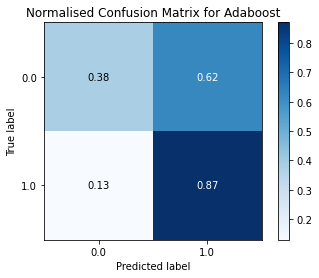

In [120]:
# Plot the normalised confusion matrix for Adaboost Classifier
skplt.metrics.plot_confusion_matrix(y_test, y_pred_abc, normalize=True, title = 'Normalised Confusion Matrix for Adaboost')
plt.show()

<AxesSubplot:title={'center':'Normalised Confusion Matrix for Logistic Regression'}, xlabel='Predicted label', ylabel='True label'>

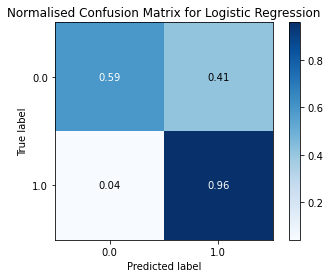

In [121]:
# Plot the normalised confusion matrix for Logistic Regression
skplt.metrics.plot_confusion_matrix(y_test, y_pred_lr, normalize=True, title = 'Normalised Confusion Matrix for Logistic Regression')

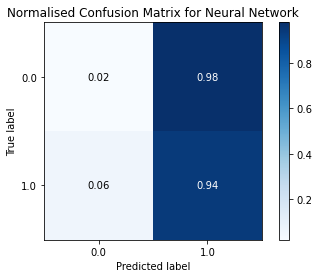

In [122]:
# Plot the normalised confusion matrix for Neural Network
skplt.metrics.plot_confusion_matrix(y_test, y_pred_nn, normalize=True, title = 'Normalised Confusion Matrix for Neural Network')
plt.show()

## ROC Curve and AUC

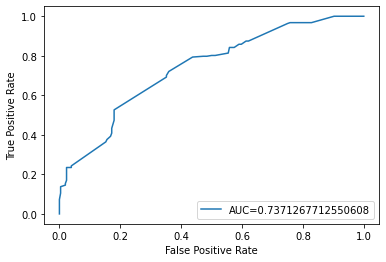

In [123]:
# Define metrics for Adaboost Classifer
y_pred_proba_abc = abc.predict_proba(X_test_scaled)[::,1]
fpr_abc, tpr_abc, _ = metrics.roc_curve(y_test,  y_pred_proba_abc)
auc_abc = metrics.roc_auc_score(y_test, y_pred_proba_abc)

#create ROC curve for Adaboost Classifer
plt.plot(fpr_abc,tpr_abc,label="AUC="+str(auc_abc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

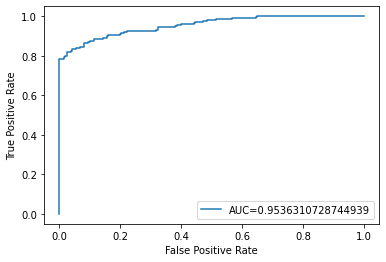

In [124]:
#define metrics for Logistic Regression
y_pred_proba_lr = logistic_regression_model.predict_proba(X_test_scaled)[::,1]
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test,  y_pred_proba_lr)
auc_lr = metrics.roc_auc_score(y_test, y_pred_proba_lr)

#create ROC curve for Logistic Regression
plt.plot(fpr_lr,tpr_lr,label="AUC="+str(auc_lr))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [125]:
# Generate the False positive rates and True positive rates for each possible threshold for Neural Network
y_pred_nn = nn.predict(X_test_scaled).ravel()
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_nn)

16/16 [==============================] - 0s 5ms/step


In [126]:
# Calculate the AUC for Neural Network
auc_nn = auc(fpr_nn, tpr_nn)

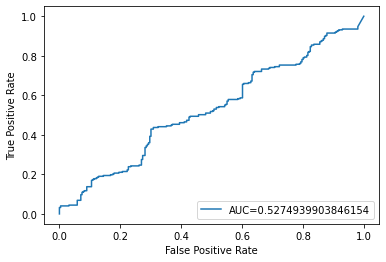

In [127]:
#create ROC curve for Neural Network
plt.plot(fpr_nn,tpr_nn,label="AUC="+str(auc_nn))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()